In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
%matplotlib inline

# Recommender Systems

We use the well-known MovieLens dataset (in this case the small version). You may find the following useful to obtain the data from the GroupLens repository, and to read it into a dataframe.

In [2]:
import os, requests
import numpy as np

#mlSize = "ml-1m"
#mlSize = "ml-100k"
mlSize = "ml-latest-small"
zipUrl = 'http://files.grouplens.org/datasets/movielens/'+mlSize+'.zip'
zipFile = 'data/'+mlSize+'.zip'
dataFile = zipFile
url = zipUrl
dataDir = 'data'
if not os.path.exists(dataDir):
    os.makedirs(dataDir)
if not os.path.isfile(zipFile):
  r = requests.get(zipUrl)
  with open(zipFile, 'wb') as f:
    f.write(r.content)

# Need to unzip the file to read its contents
import zipfile
with zipfile.ZipFile(zipFile,"r") as zip_ref:
  zip_ref.extractall(dataDir)

movies = pd.read_csv('data/ml-latest-small/movies.csv')
ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
tags = pd.read_csv('data/ml-latest-small/tags.csv')

# Data preparation
Lets take a quick look at the data

In [3]:
print('movies count', len(movies))

# checking for duplicates
print('no of duplicate row', len(movies) - movies['movieId'].nunique())

movies.head()

movies count 9742
no of duplicate row 0


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print('rating count', len(ratings))
ratings.head()

rating count 100836


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


The tags contains lots of duplicates. We will resolve this by using the first occurence as the value.

In [5]:
print('tag size before removing duplicates', len(tags))

tags = tags[['tag', 'movieId']]
tags.dropna(subset=['movieId', 'tag'], inplace=True)
# dropping ALL duplicte values 
tags.drop_duplicates(subset ='movieId', inplace = True) 
print('size of tags now', len(tags))
tags.head()

tag size before removing duplicates 3683
size of tags now 1572


,tag,movieId
0,funny,60756
3,Boxing story,89774
6,drugs,106782
9,way too long,48516
10,Al Pacino,431


As you can see, the movies only contain {id, title, genres}, while the ratings {user id, movie id, rating}

We can merge these dataset

In [6]:
df = pd.merge(ratings, movies, on='movieId', how='left')
df = pd.merge(df, tags, on='movieId', how='left')
df.drop('timestamp', axis=1, inplace=True)
print('rating size', len(df))
df.head()

rating size 100836


,userId,movieId,rating,title,genres,tag
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,moldy
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,NaN
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,mystery
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,mindfuck


Much better. Now lets take a look at the data

In [7]:
print('unique users: ', df['userId'].nunique())
print('unique movies: ', df['movieId'].nunique())
print()
print('Checking for null values')
print(df.isnull().sum())

unique users:  610
unique movies:  9724

Checking for null values
userId         0
movieId        0
rating         0
title          0
genres         0
tag        52549
dtype: int64


Ok, we are good. there don't seem to have any null values in our dataset.

# Data analysis
Lets take a look at the ratings people give to the movies.

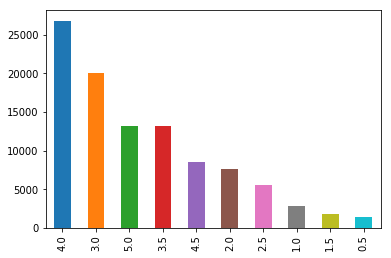

In [8]:
df['rating'].value_counts().plot(kind='bar')
plt.show()

Now lets take a look at the average ratings the movies get.

In [9]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

Seems odd that the highly rated movies are titles that are not popular. But this is expected behavior as we are sorting them by the average rating. Outliers created by one or two users rating a movie 5/5 will be present in this list (as shown in the next plot below)

Now lets observe the ratings again, this time including the number of ratings each movie received.

In [10]:
meanRatings = pd.DataFrame(df.groupby('title')['rating'].mean())
meanRatings['count'] = df.groupby('title')['rating'].count()
meanRatings.sort_values(by='rating',ascending=False).head(10)

,rating,count
title,,
Gena the Crocodile (1969),5.0,1
True Stories (1986),5.0,1
Cosmic Scrat-tastrophe (2015),5.0,1
Love and Pigeons (1985),5.0,1
Red Sorghum (Hong gao liang) (1987),5.0,1
"Thin Line Between Love and Hate, A (1996)",5.0,1
Lesson Faust (1994),5.0,2
Eva (2011),5.0,1
Who Killed Chea Vichea? (2010),5.0,1


As you can see, there are a number of outliers present in the data.

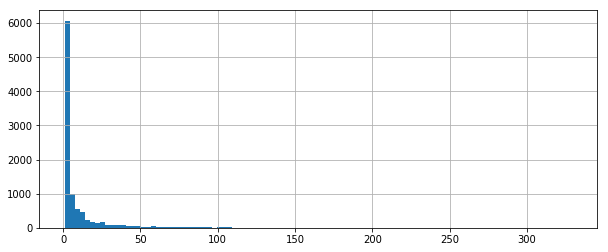

In [11]:
plt.figure(figsize=(10,4))
meanRatings['count'].hist(bins=100)

We also realise that most movies have not been rated by users. This makes sense as everybody cannot rate every single movies.

Now let's only consider movies that have been rated x amount of times

In [12]:
minMovieRatings = 100

filteredMovies = df['movieId'].value_counts() > minMovieRatings
filteredMovies = filteredMovies[filteredMovies].index

filteredDf = df[df['movieId'].isin(filteredMovies)]

print('df size is', len(df))
print('filteredDf size is', len(filteredDf))

df size is 100836
filteredDf size is 19788


In [13]:
# update the meanRatings df
meanRatings = pd.DataFrame(filteredDf.groupby('title')['rating'].mean())
meanRatings['count'] = filteredDf.groupby('title')['rating'].count()

meanRatingsUsers = pd.DataFrame(filteredDf.groupby('userId')['rating'].mean())
meanRatingsUsers['count'] = filteredDf.groupby('userId')['rating'].count()

print('here is the top 10 rated movies')
meanRatings.sort_values(by='rating',ascending=False).head(10)

here is the top 10 rated movies


,rating,count
title,,
"Shawshank Redemption, The (1994)",4.429022,317
"Godfather, The (1972)",4.289062,192
Fight Club (1999),4.272936,218
"Godfather: Part II, The (1974)",4.259690,129
"Departed, The (2006)",4.252336,107
Goodfellas (1990),4.250000,126
"Dark Knight, The (2008)",4.238255,149
"Usual Suspects, The (1995)",4.237745,204
"Princess Bride, The (1987)",4.232394,142


As you can see, now the top rated movies are more realistic.

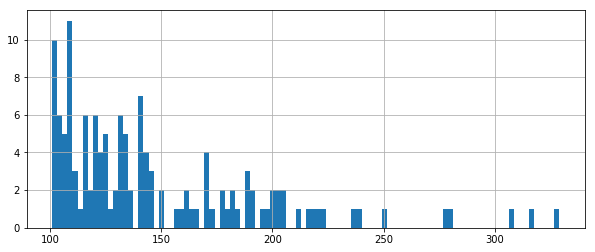

In [14]:
plt.figure(figsize=(10,4))
meanRatings['count'].hist(bins=100)

I think we have filtered the outlier well enough to proceed with the task.

Now let's see the actual distribution of the ratings

The first plot is the histogram of ratings user give to movies

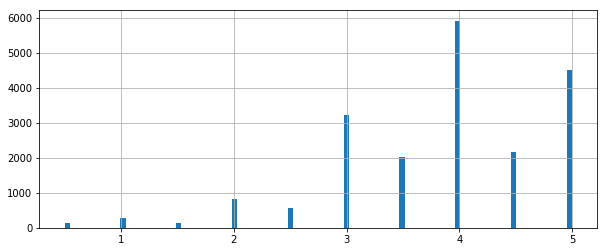

In [15]:
plt.figure(figsize=(10,4))
filteredDf['rating'].hist(bins=100)

The second plot is the histogram of the MEAN rating each user give

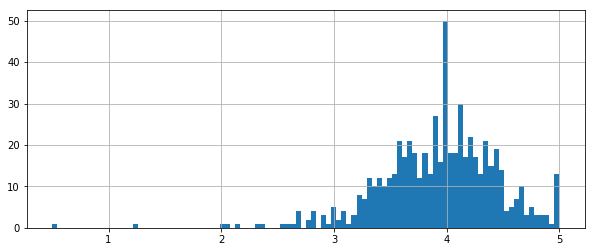

In [16]:
plt.figure(figsize=(10,4))
meanRatingsUsers['rating'].hist(bins=100)

This plot is the histogram of the MEAN movies rating

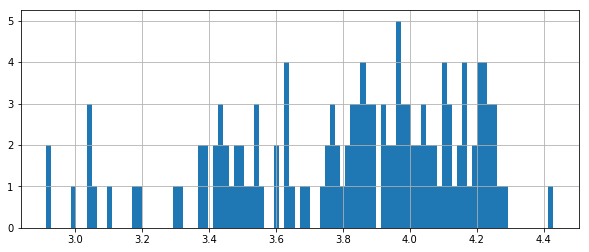

In [17]:
plt.figure(figsize=(10,4))
meanRatings['rating'].hist(bins=100)

As you can see, in all cases, most of the movies are rated about 4 stars. The trend observed in the average ratings users give and average ratings movies received are well correlated. Notice that there are also a considerable number of movies with perfect 5 stars. Let's see if they are outliers.

In [18]:
# get all the data that rate movies at 5 stars
movie5 = filteredDf[filteredDf['rating'] == 5]
print('size of the dataframe', len(movie5))

newDf = df[df['movieId'].isin(movie5['movieId'])]
newDf['title'].value_counts().sort_values(ascending=True).head()

size of the dataframe 4509


Cliffhanger (1993)          101
Firm, The (1993)            101
Outbreak (1995)             101
Full Metal Jacket (1987)    102
Trainspotting (1996)        102
Name: title, dtype: int64

As you can see, all these 5 rated movies have at least the min number of ratings that we set.

Now let's see how the number of people rating a movie correlates to how good the movie actually is.

/miniconda3/envs/py3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


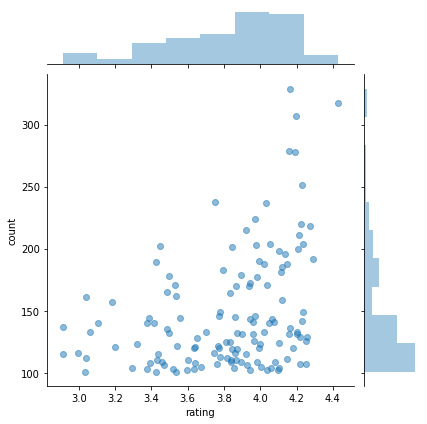

In [19]:
sns.jointplot(x='rating', y='count', data=meanRatings, alpha=0.5)

Here we can observe that as we get more number of ratings, the movie is more likely to have better ratings.

# Testing the dataset with surprise

In [20]:
from surprise import SVD, SlopeOne, NMF, KNNBasic
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# convert df to surprise dataset format and set its reader to our rating system
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(filteredDf[['userId', 'movieId', 'rating']],reader)

The next step is to benchmark the dataset with 4 famous algorithms. SVD, SlopeOne, NMF, KNNBasic.

In [21]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), NMF(), KNNBasic()]:
    algoName = str(algorithm).split(' ')[0].split('.')[-1]
    # Perform cross validation
    result = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(result).mean(axis=0)
    tmp = tmp.append(pd.Series([algoName], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.823711,1.014185,0.064696
SlopeOne,0.825828,0.023647,0.249508
NMF,0.849514,0.945592,0.046569
KNNBasic,0.853897,0.071982,1.328152


# Evaluation
Our recommender system uses a collaborative filtering technique in order to suggest new movies to a user based on the user previous behaviour or other similar user's behaviour.

The shape of our dataset is sparse, with each user rating only a few movies, while there are a large amount of unrated movies. So the problem is on how to choose the best movies to recommend to users.

The algorithm with the lowest RMSE are SVD and SlopeOne, with very close difference in accuracy. Let's discuss the strengths and weaknesses of these two contenders.

Singular vector decomposition (SVD) shown here employs the use of gradient descent to minimize the squared error between predicted rating and actual rating. It uses Latent Semantic Indexing (LSI), which is a dimensionality reduction technique. This maps nicely to our dataset, hence gives the lowest RMSE with the lowest test time.

Slope One method operates with average differences of ratings between each item and makes predictions based on their weighted value. Suppose there are n items, m users, and N ratings. Computing the average rating differences for each pair of items requires up to n(n-1)/2 units of storage, and up to m n2 time steps. With larger dataset, it will requrie tons of computation power and space.

From this findings, we can conclude that SVD is the better algorithm to use due to its high accuracy and speed. Speed is really important for scalability as in production, the dataset will be very large.

# Testing out the recommender system
Finally it is time. With the prediction matrix generated for each user, I can build a function to recommend movies for any user. All that is required is to return a list of movies that the specified user has not rated, sorted by its predicted rating.

We can pick a random user X

In [22]:
# First train an SVD algorithm on the movielens dataset.
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

Here is the top 5 movies rated by user X

In [23]:
n = 5
uid = 11

userX = filteredDf[filteredDf['userId'] == uid]
userX.sort_values(by='rating',ascending=False).head(n)

,userId,movieId,rating,title,genres,tag
1259,11,6,5.0,Heat (1995),Action|Crime|Thriller,NaN
1272,11,349,5.0,Clear and Present Danger (1994),Action|Crime|Drama|Thriller,Tom Clancy
1313,11,1721,5.0,Titanic (1997),Drama|Romance,shipwreck
1287,11,593,5.0,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,Hannibal Lector
1279,11,457,5.0,"Fugitive, The (1993)",Thriller,based on a TV show


User X likes to watch {Action, Thriller and Crime}

Here is the top 5 movies that user X will most likely rate highly

In [24]:
predX = list(filter(lambda p: p.uid == uid, predictions))

Here we check that all the predictions exclude movies that user X has already rated.

In [25]:
recX = pd.DataFrame(predX)
print('movie id similarities:', len(recX[recX['iid'].isin(userX['movieId'])]))

movie id similarities: 0


In [26]:
recX.drop('details', axis=1, inplace=True)
recX.rename(columns={'iid': 'movieId'}, inplace=True)
recX = pd.merge(recX, movies, on='movieId', how='left')
recX = pd.merge(recX, tags, on='movieId', how='left')

recX.sort_values(by='est',ascending=False).head(n)

,uid,movieId,r_ui,est,title,genres,tag
5,11,260,3.859536,4.739105,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,classic
18,11,1196,3.859536,4.707001,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,I am your father
90,11,858,3.859536,4.695415,"Godfather, The (1972)",Crime|Drama,Mafia
19,11,1197,3.859536,4.672092,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Inigo Montoya
17,11,1136,3.859536,4.656945,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,british comedy


The system predicts that User X will like {Action, Crime and Drama}

Great. looks like our recommender system is predicting correctly what this user wants.